In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap

%matplotlib inline
rcParams['figure.figsize'] = (12, 10)
from wordcloud import WordCloud

In [5]:
file_path = '/Users/Dracarys/Documents/data/'

In [6]:
trump_df = pd.read_csv(file_path + 'trump_location_filled.csv')

In [8]:
hillary_df = pd.read_csv(file_path + 'hillary_location_filled.csv')

In [9]:
all_df = hillary_df.append(trump_df)
len(all_df)

1240276

In [10]:
all_df.drop_duplicates(subset='id', inplace=True)
len(all_df)

1222413

In [28]:
all_df.sample(3)

,user,date,id,text,userid,loc,state,lat,lon,hashtag,2clusters
209330,GoLeftYoungMan,2016-10-26 19:21:31,791419518534942720,Southern Democrats were filled with zealous bi...,220712406,"New York City, NY",LA,40.730646,-73.986614,['#TrumpTrain'],0
782835,girl_wyoming,2016-10-09 02:08:04,784998846950629376,timkaine I would rather hang myself then have ...,1931263520,"Wyoming, USA",WY,43.170026,-107.568535,"['#NeverHillary', '#NeverYou', '#AssHat']",0
50459,RoseCarol3,2016-10-10 11:38:22,785504756253024256,Which private policy did not let answer 600 3A...,511177454,"NY, NJ, PA, CT",CT,40.644002,-73.804399,"['#Hillary', '#Benghazi', '#ClintonFoundation']",0


In [41]:
all_df.fillna('', inplace=True)

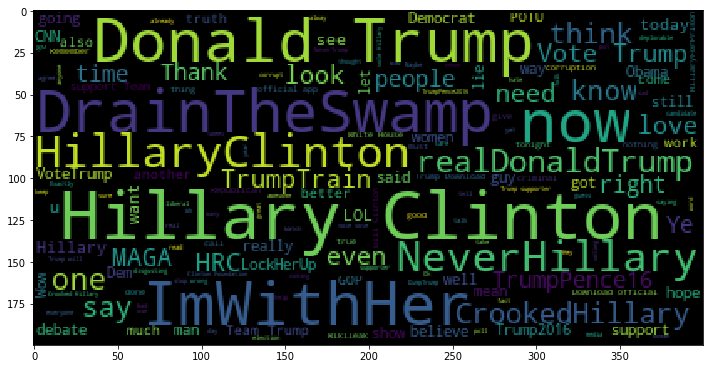

In [14]:
wordcloud = WordCloud().generate(' '.join(all_df.text) )
# plt.figure(figsize=(13, 13))
plt.imshow(wordcloud)

In [15]:
tweet_stop_words = text.ENGLISH_STOP_WORDS.union(['did', 'just', 'don', 'time', 'know', 'going', 'say', 'think', 'way', 'said', 'new', 'does', 'day', 'days', 'years', 'got', 'says', 'doesn', 'll', 've', 'twitter', 'pic', 'com', 'let', 'voting', 'rt', 'want', 'country', 'today', 'early', 'tonight', 'thing', 'didn', 'come', 'coming', 'tell', 'read'])

In [17]:
tfidf_vect = TfidfVectorizer(stop_words=tweet_stop_words, max_df=.95, min_df=2)
matrix = tfidf_vect.fit_transform(all_df.text)

In [18]:
kmeans = MiniBatchKMeans(n_clusters=2) # faster kmeans algorithm
kmeans.fit(matrix)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=2,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [19]:
lons = list(all_df.lon)
lats = list(all_df.lat)

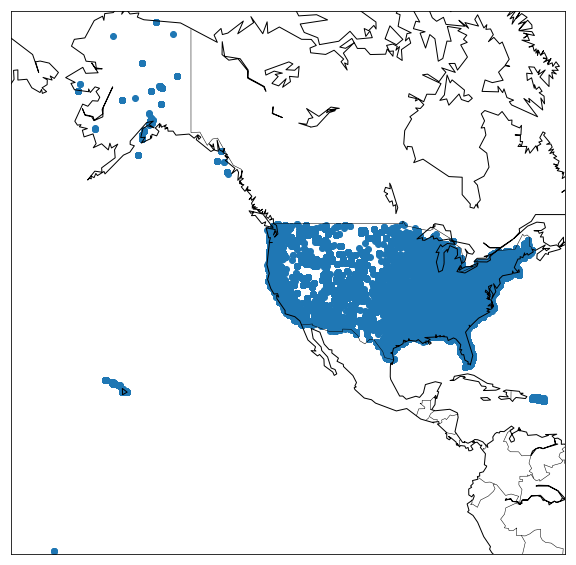

In [20]:
my_map = Basemap(projection='merc', resolution='c',
                llcrnrlat=-15, urcrnrlat=71,
                llcrnrlon=-180, urcrnrlon=-60)

x, y = my_map(lons, lats)
my_map.scatter(x, y)

my_map.drawcoastlines()
my_map.drawcountries()

In [23]:
all_df['2clusters'] = kmeans.labels_

In [25]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1], dtype=int32), array([1120653,  101760]))

In [26]:
def kmeans_plot_map_legend(matrix, vectorizer, kmeans, lat_lon_df, num_terms=10):
    '''plot sctter plots for different clustering base on kmeans, but also plot the legends as well
    matrix -- a sparse matrix, after you call fit_transform over all_tweets dataframe
    vectorizer -- the vectorizer you used to do fit_transform on all_tweets
    kmeans : kmeans model, should be already fit
    lat_lon_df : a pandas dataframe containing latitudes and longitudes'''
    my_map = Basemap(projection='merc', resolution='c',
                llcrnrlat=-15, urcrnrlat=71,
                llcrnrlon=-180, urcrnrlon=-60)
    
    terms = vectorizer.get_feature_names()
    lons, lats = lat_lon_df.lon.values, lat_lon_df.lat.values
    for k in range(kmeans.n_clusters):
        current_lons = lons[ kmeans.labels_ == k ]
        current_lats = lats[ kmeans.labels_ == k ]
        
        legends = ''
        for count, index in enumerate(np.argsort(-kmeans.cluster_centers_[k]) ):
            if count >= num_terms:
                break
            legends += terms[index] + ', '
        
        x, y = my_map(current_lons, current_lats)
        my_map.scatter(x, y, label=legends)
        
    my_map.drawcoastlines()
    my_map.drawcountries()
    plt.legend()

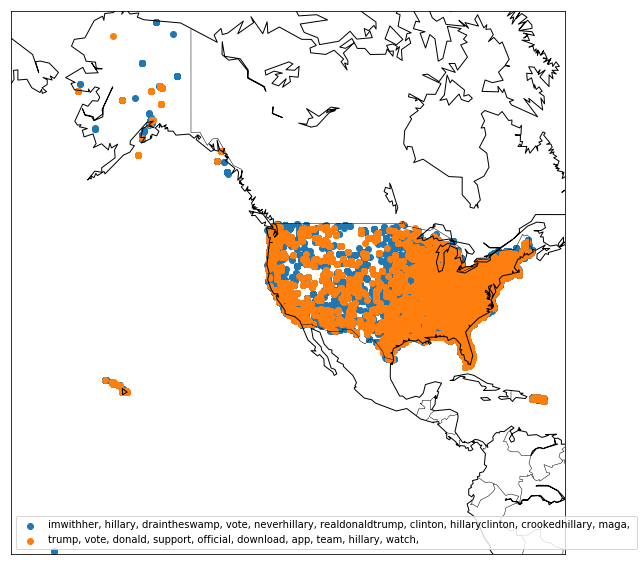

In [27]:
kmeans_plot_map_legend(matrix, tfidf_vect, kmeans, all_df)

In [29]:
def get_labels(matrix, vectorizer, kmeans, num_terms=10):
    '''return a dict, key : value, key -- label number, value -- important key terms'''
    labels_dict = {}
    terms = vectorizer.get_feature_names()
    
    for k in range(kmeans.n_clusters):
        key_terms = []
        for count, index in enumerate(np.argsort(-kmeans.cluster_centers_[k])):
            if count >= num_terms:
                break
            key_terms.append(terms[index])
        labels_dict[k] = ', '.join(key_terms)
    return labels_dict

In [50]:
clusters2_dict = get_labels(matrix, tfidf_vect, kmeans)

In [31]:
all_df.state.unique()

array(['AK', 'AL', 'AR', 'AZ', 'NC', 'CA', 'CO', 'CT', 'FL', 'DC',
       'District of Columbia', 'DE', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN',
       'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MO', 'MN', 'MS', 'OH',
       'MT', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OK', 'OR', 'PA',
       'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV',
       'WY', nan, 'Northern Mariana Islands', 'Puerto Rico',
       'United States Virgin Islands', 'American Samoa (land)', 'Guam'], dtype=object)

In [36]:
all_df.loc[(all_df.state == 'District of Columbia'), 'state'] = 'DC'

In [37]:
all_df.state.unique()

array(['AK', 'AL', 'AR', 'AZ', 'NC', 'CA', 'CO', 'CT', 'FL', 'DC', 'DE',
       'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD',
       'ME', 'MI', 'MO', 'MN', 'MS', 'OH', 'MT', 'ND', 'NE', 'NH', 'NJ',
       'NM', 'NV', 'NY', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', nan,
       'Northern Mariana Islands', 'Puerto Rico',
       'United States Virgin Islands', 'American Samoa (land)', 'Guam'], dtype=object)

In [75]:
def plot_map_kmeans_labels(lat_lon_df, labels, cluster_name, title, resolution='r'):
    '''plot scatter plots for the whole lat_lon_df with given labels
    lat_lon_df : a pandas dataframe containing latitudes and longitudes
    labels : a dict, key -- label number, value -- labels we are going to legend
    2clusters : a string, the access label we could use to get label from lat_lon_df
    resolution : resolution of boundary database to use. Can be c (crude), l (low), i (intermediate), h (high), f (full) or None
    title : a string, title for this plot
    '''
    lat_min, lat_max = lat_lon_df.lat.min() - 1, lat_lon_df.lat.max() + 1
    lon_min, lon_max = lat_lon_df.lon.min() - 1, lat_lon_df.lon.max() + 1
    
    my_map = Basemap(projection='merc', resolution=resolution,
                llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max)
    
    lons, lats = lat_lon_df.lon.values, lat_lon_df.lat.values
    for key in labels:
        index_array = lat_lon_df[cluster_name] == key
        current_lons = lons[ index_array ]
        current_lats = lats[ index_array ]        
        x, y = my_map(current_lons, current_lats)
        my_map.scatter(x, y, label=labels[key])
        
    my_map.drawcoastlines()
    my_map.drawcountries()
    plt.legend()
    plt.title(title)
    plt.show()

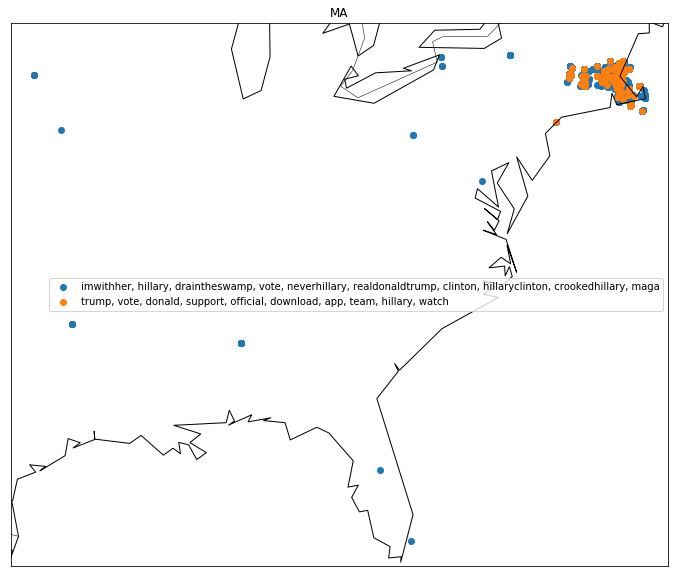

In [68]:
plot_map_kmeans_labels(ma_df, clusters2_dict, '2clusters', 'MA')

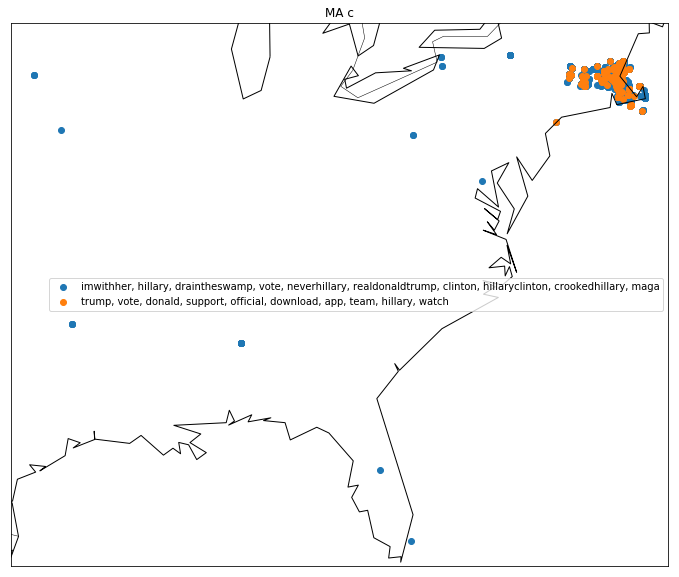

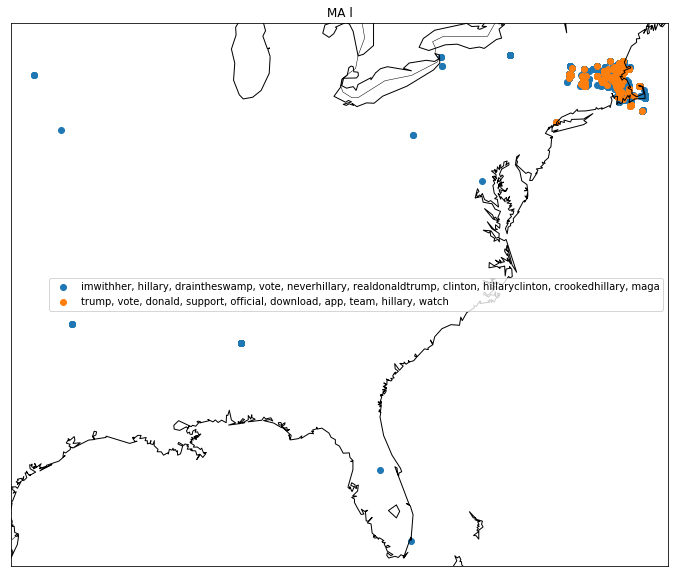

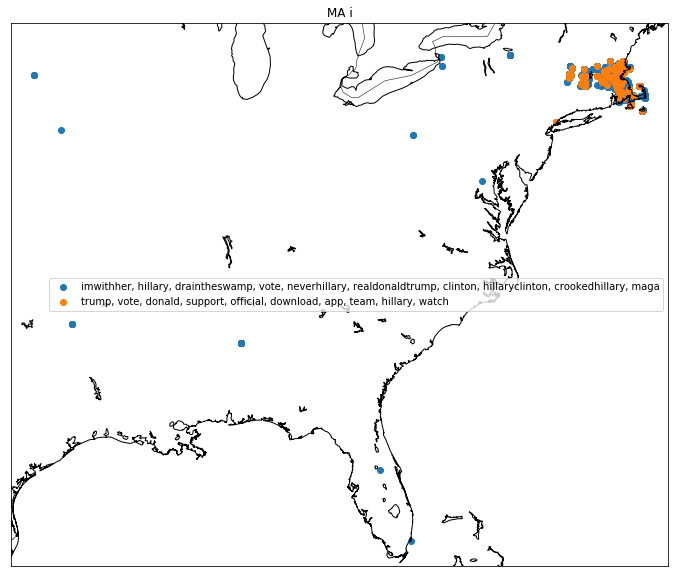

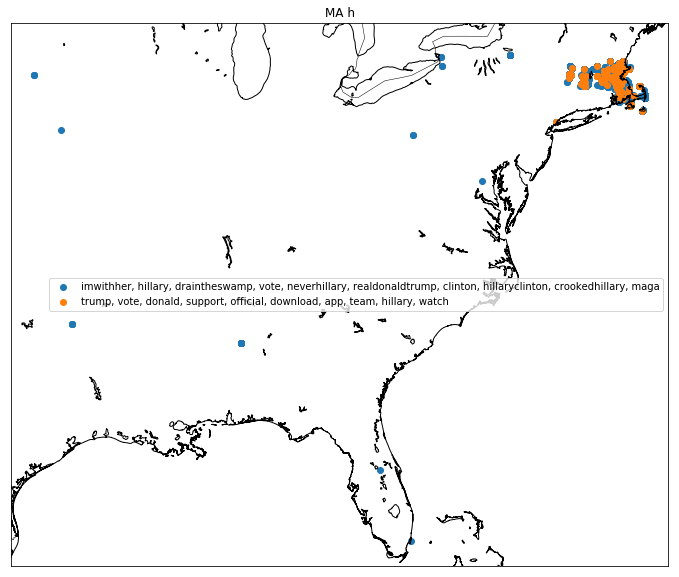

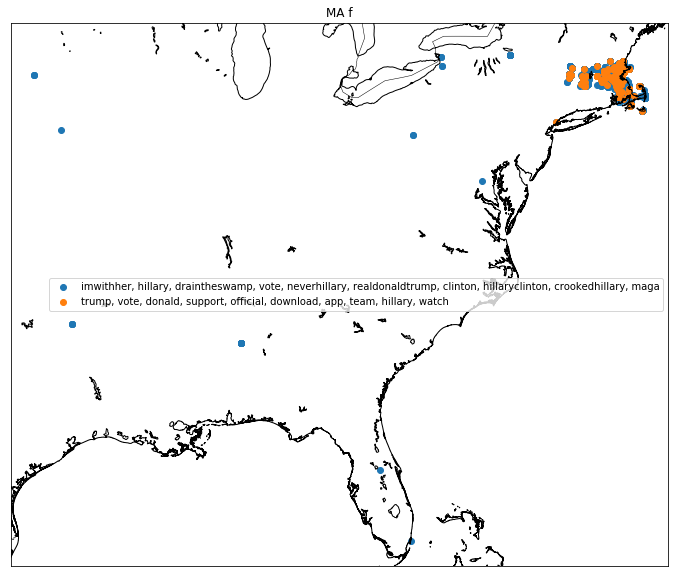

TypeError: must be str, not NoneType

In [76]:
for resolution in ['c', 'l', 'i', 'h', 'f', None]:
    plot_map_kmeans_labels(ma_df, clusters2_dict, '2clusters', 'MA ' + resolution, resolution)

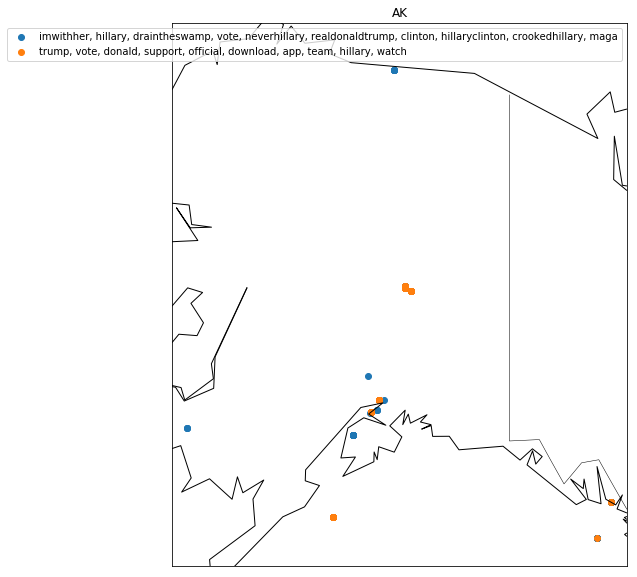

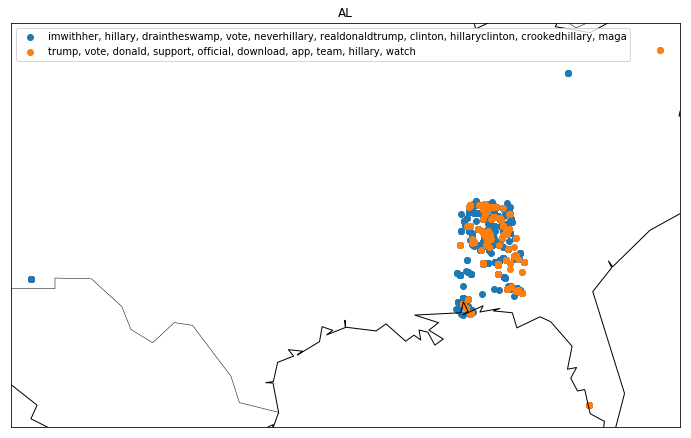

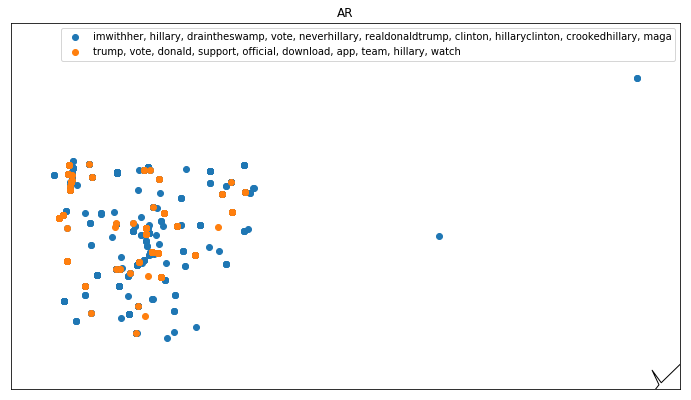

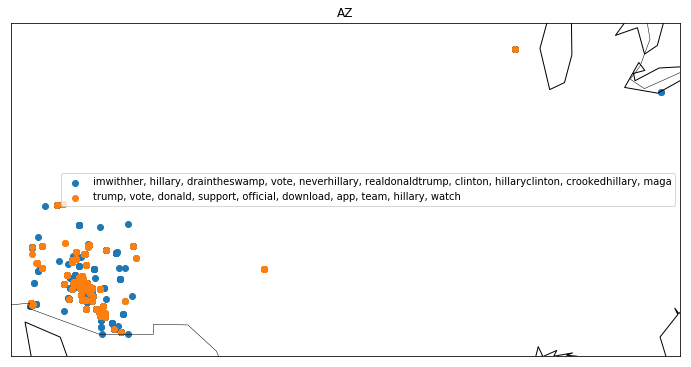

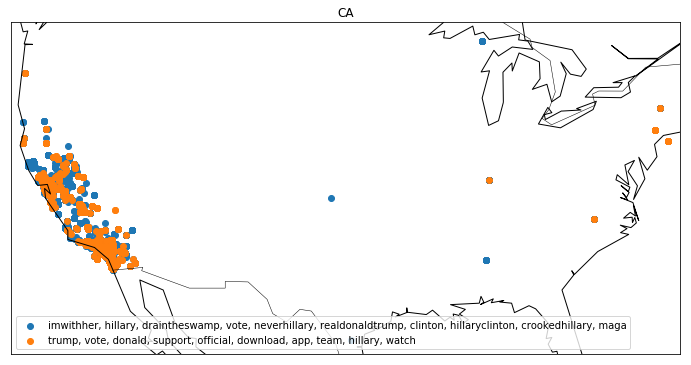

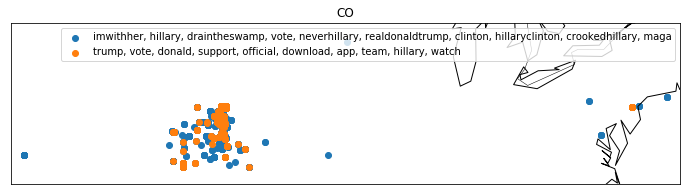

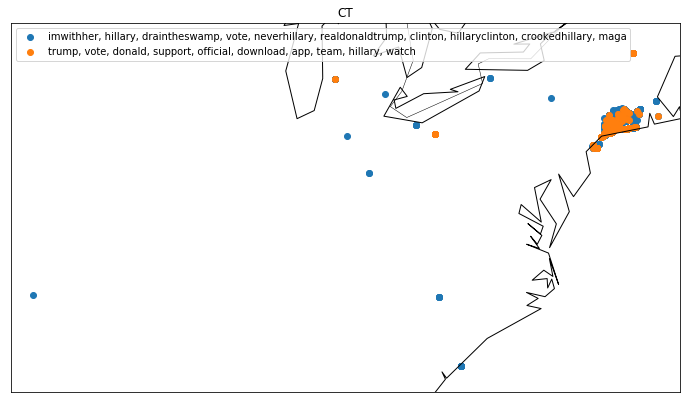

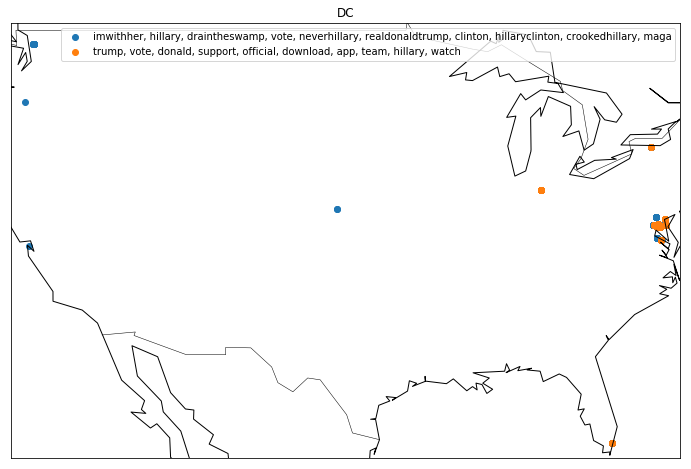

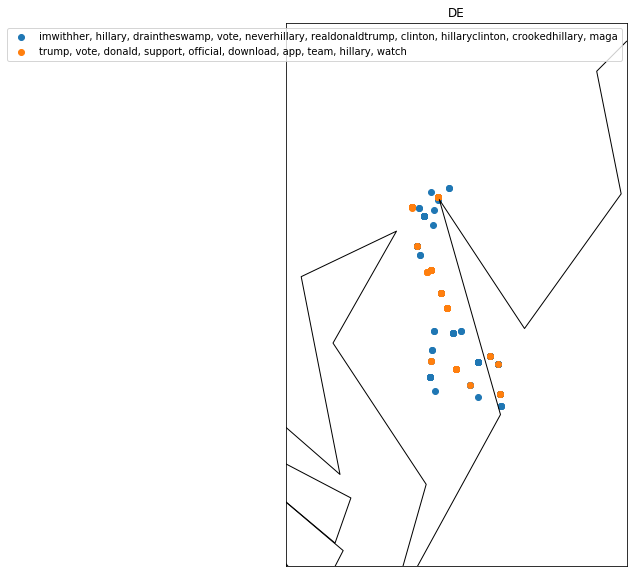

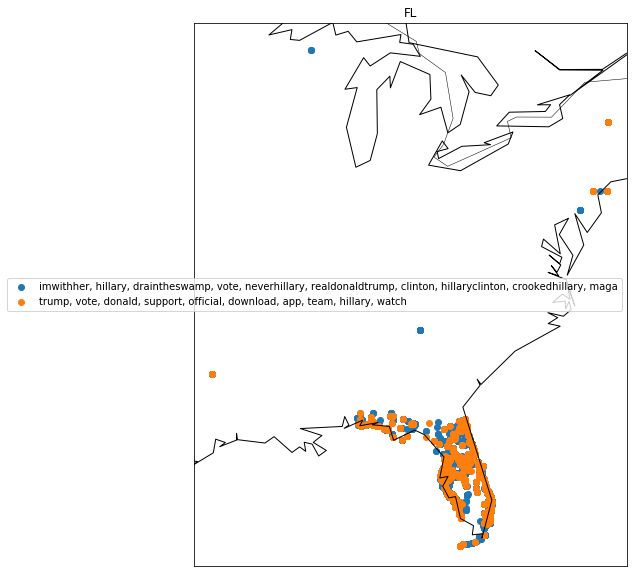

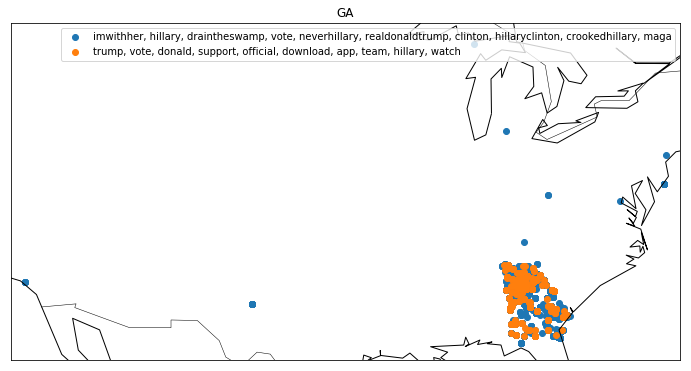

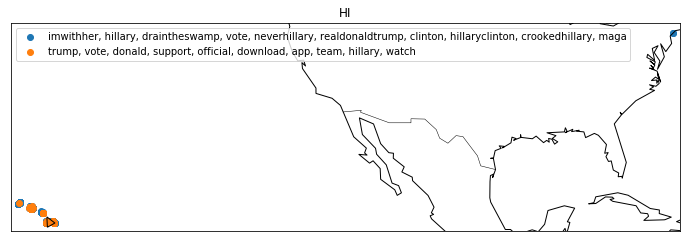

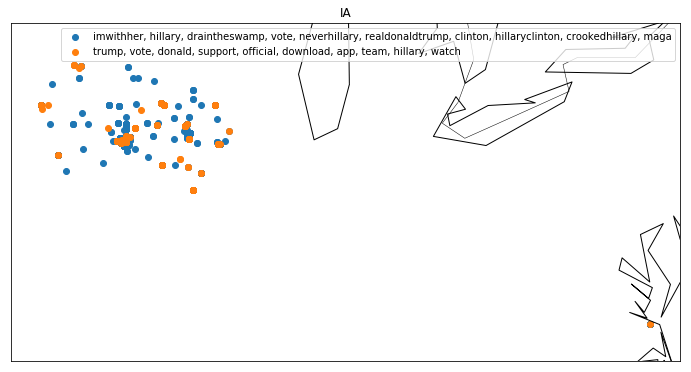

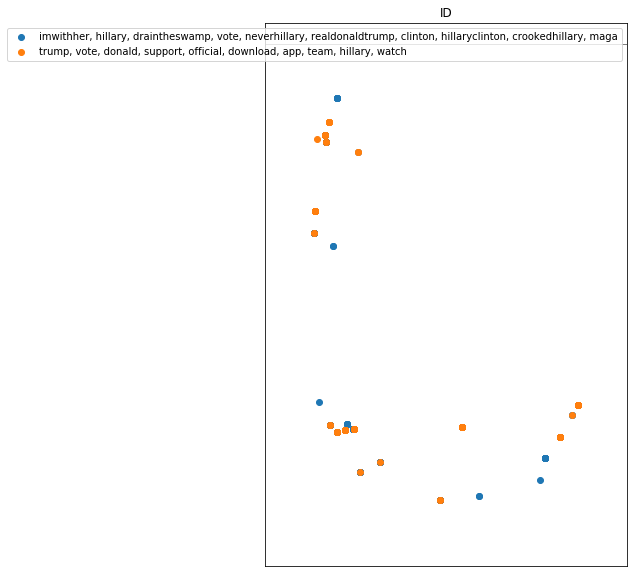

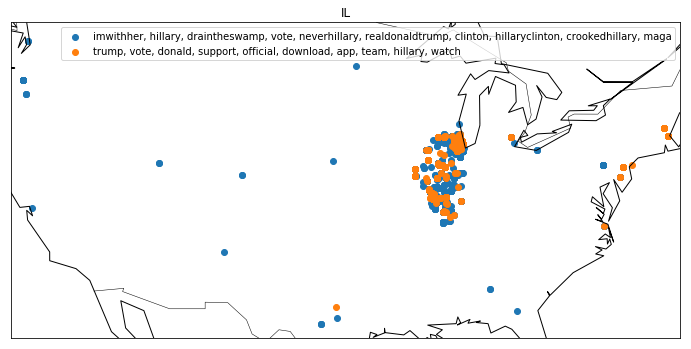

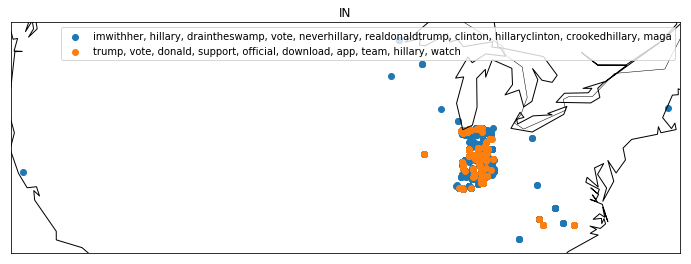

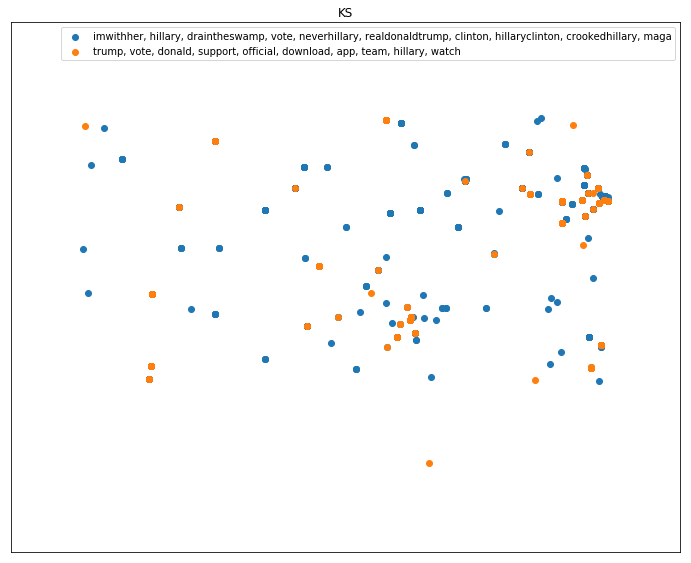

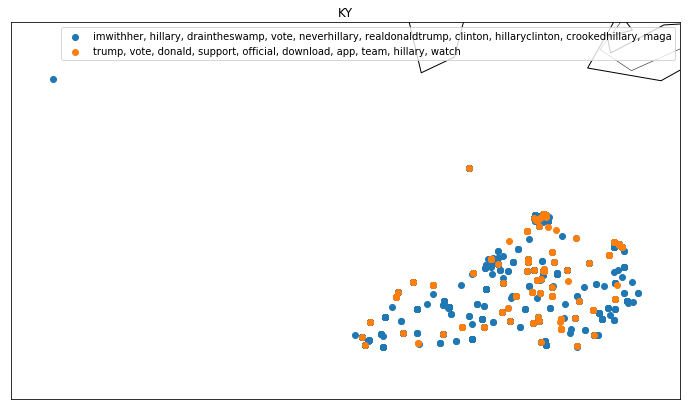

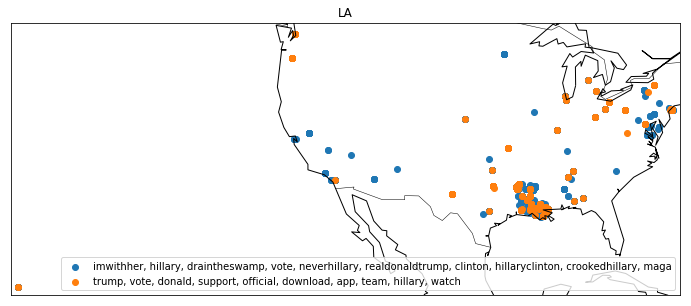

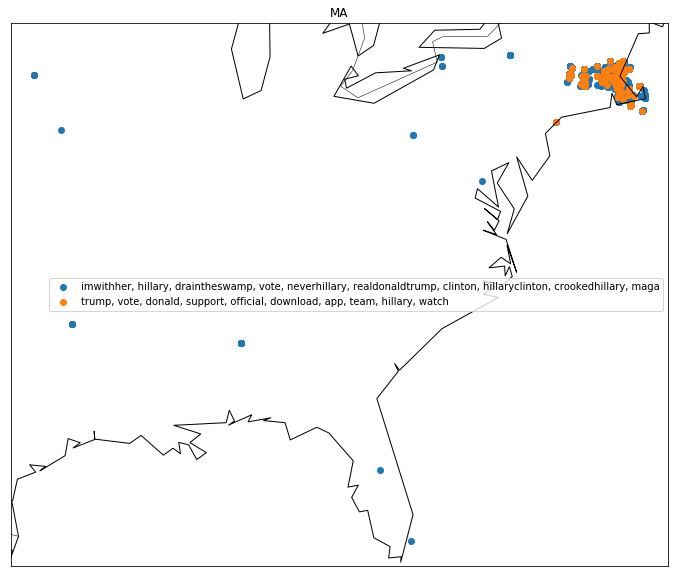

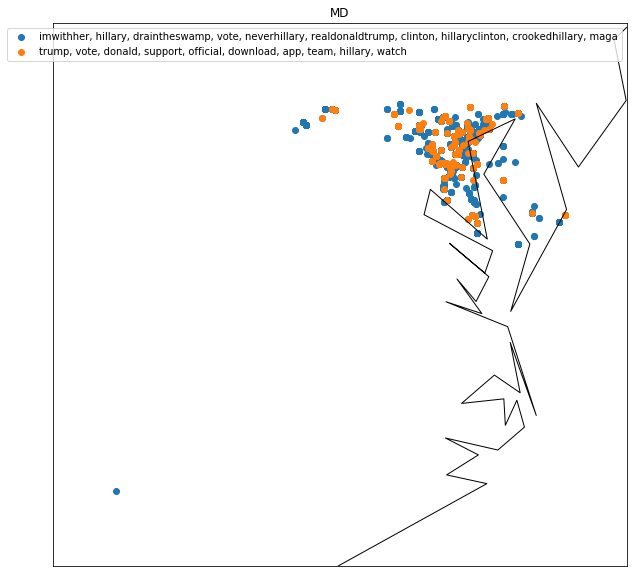

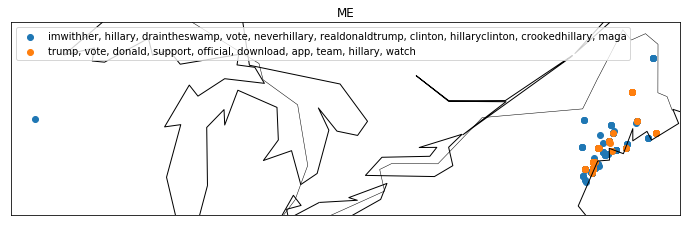

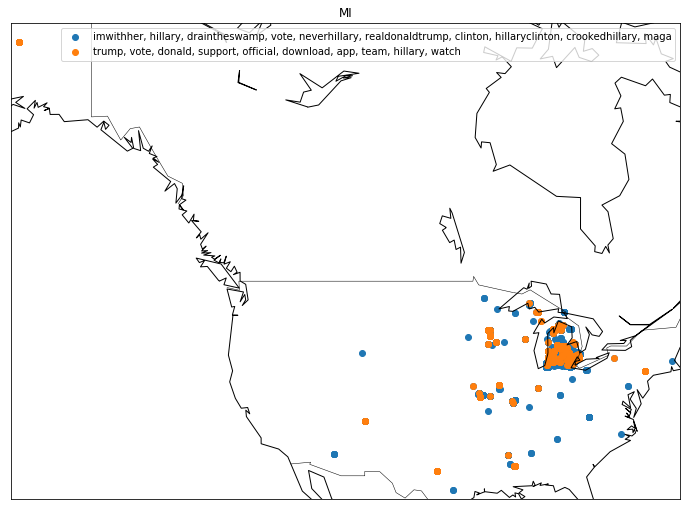

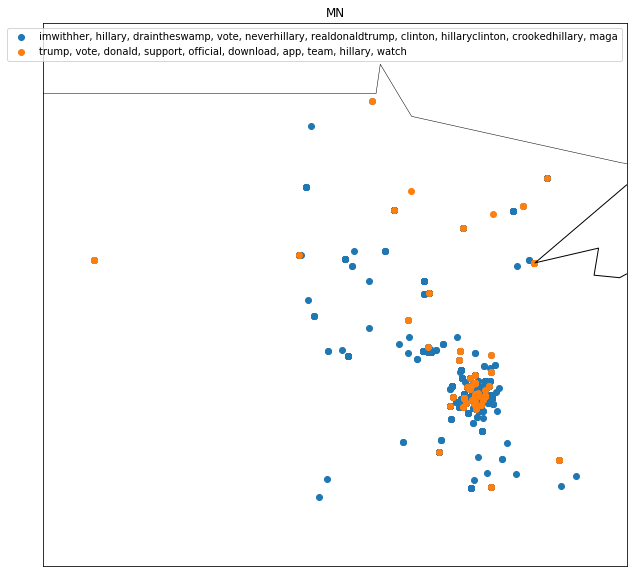

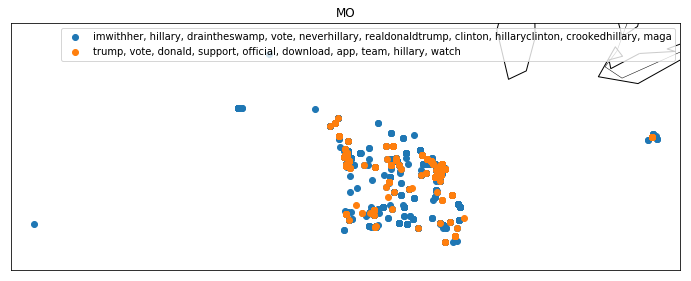

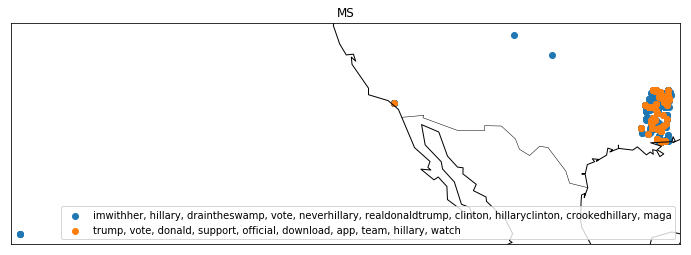

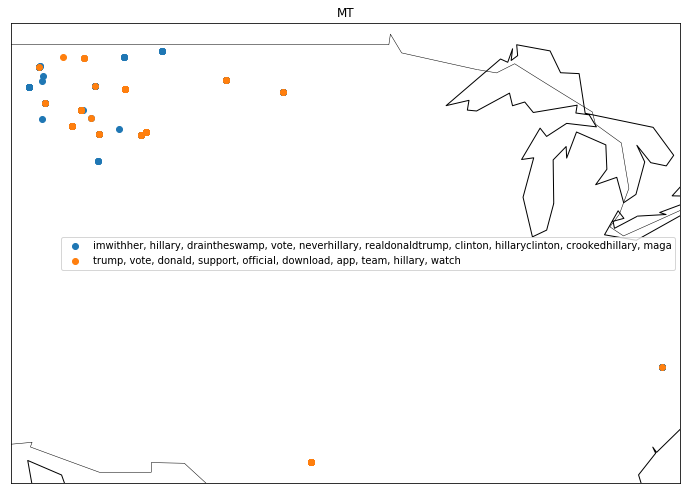

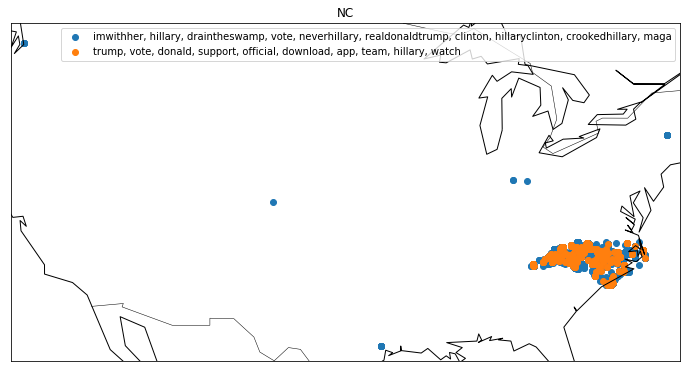

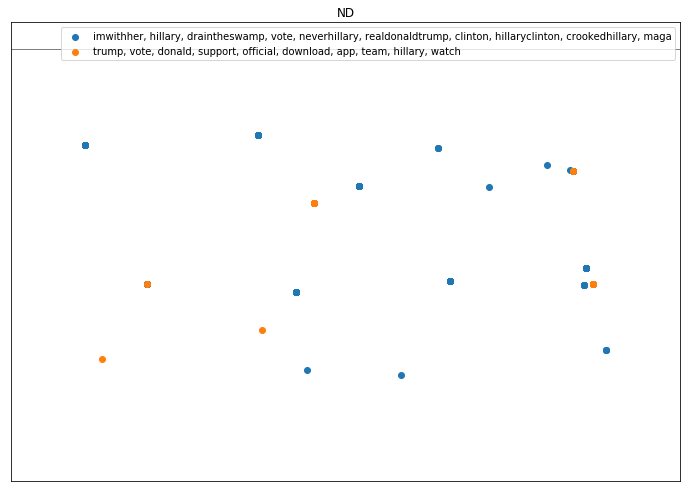

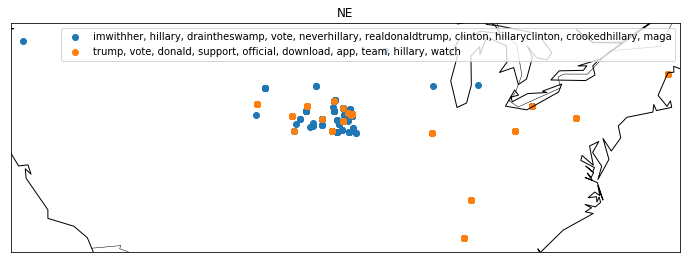

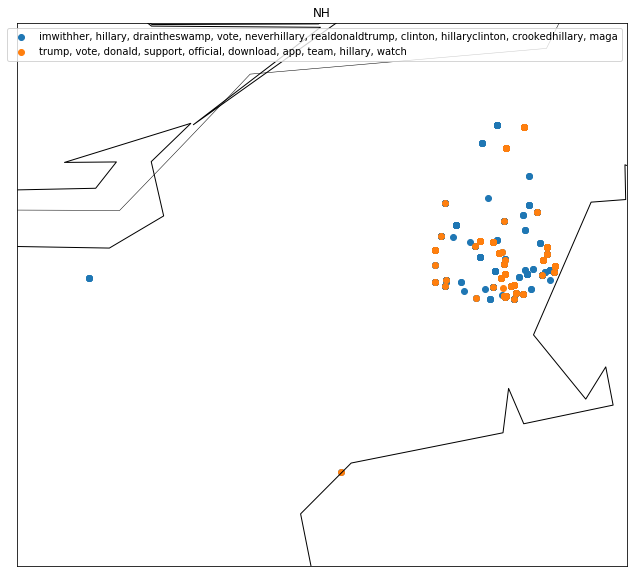

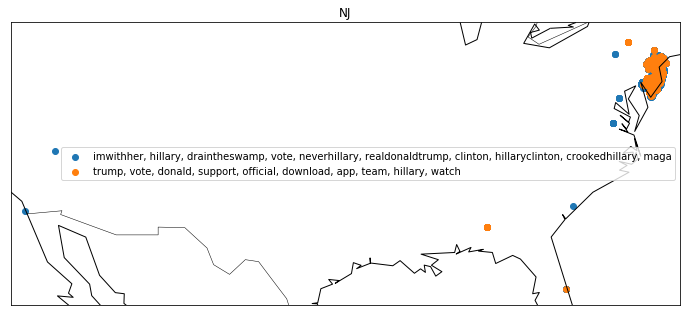

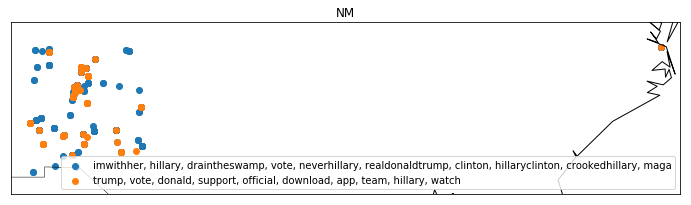

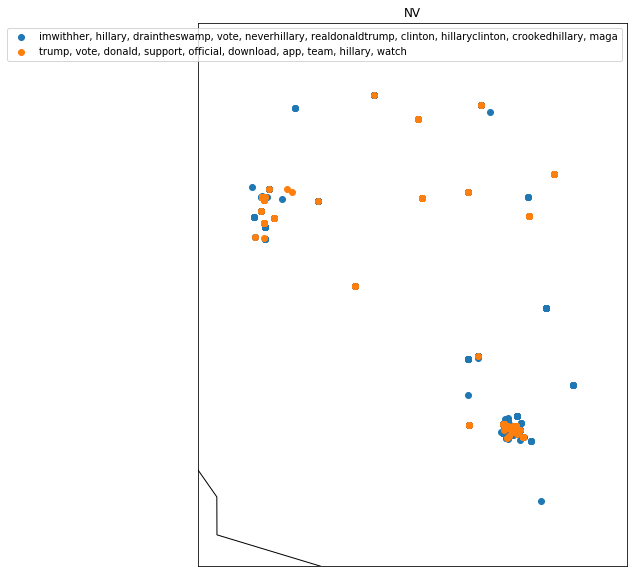

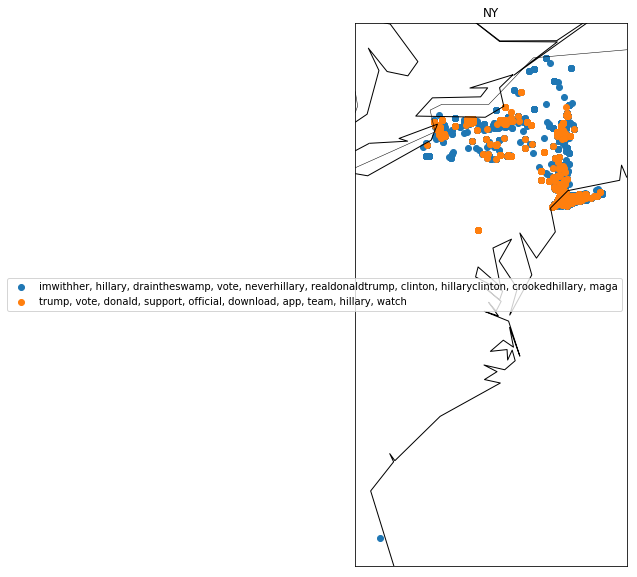

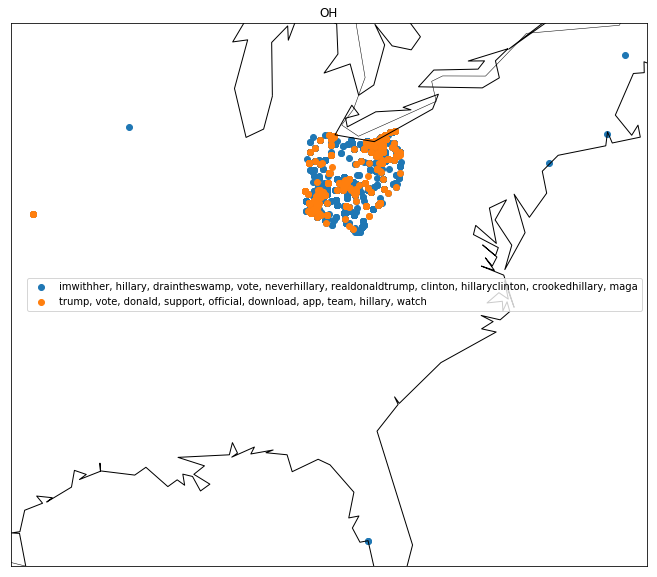

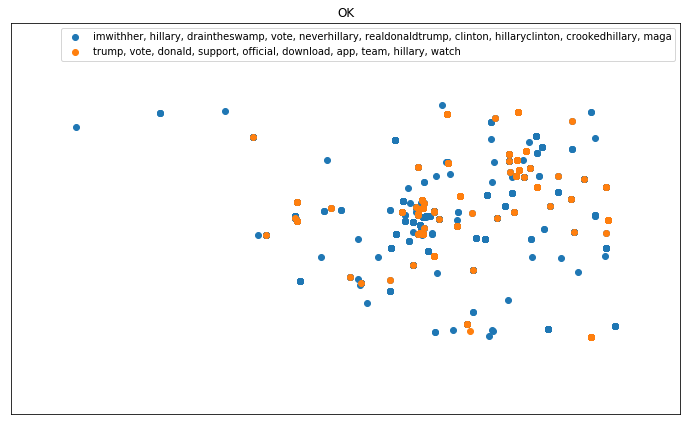

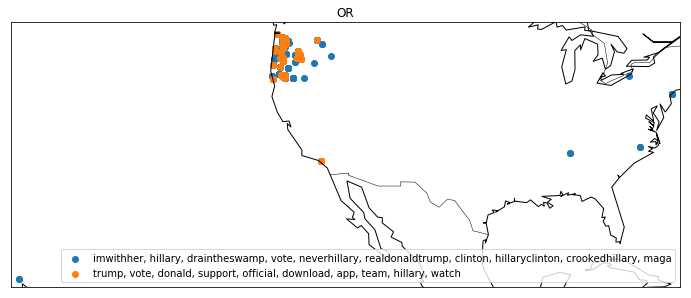

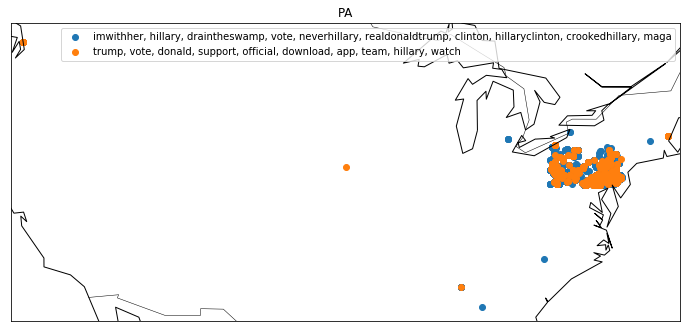

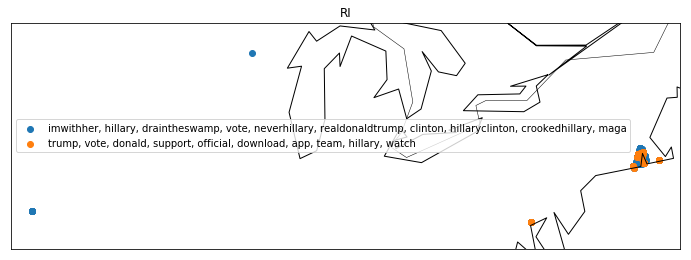

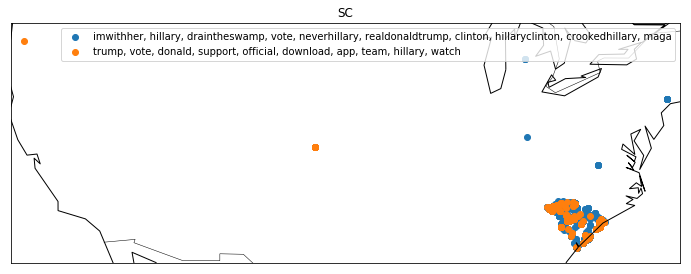

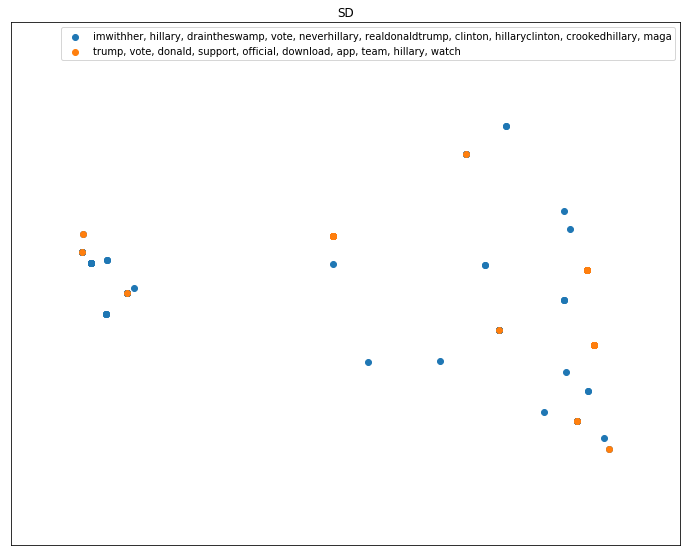

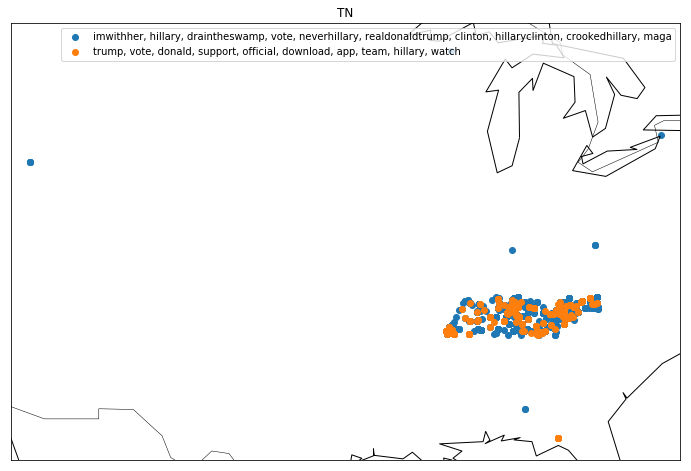

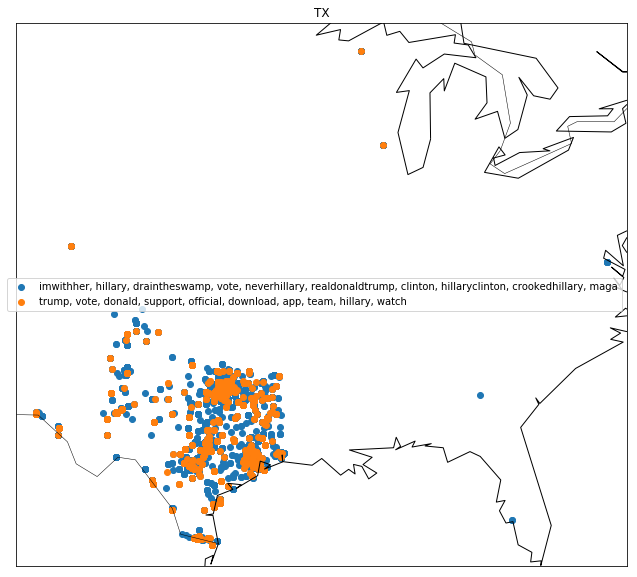

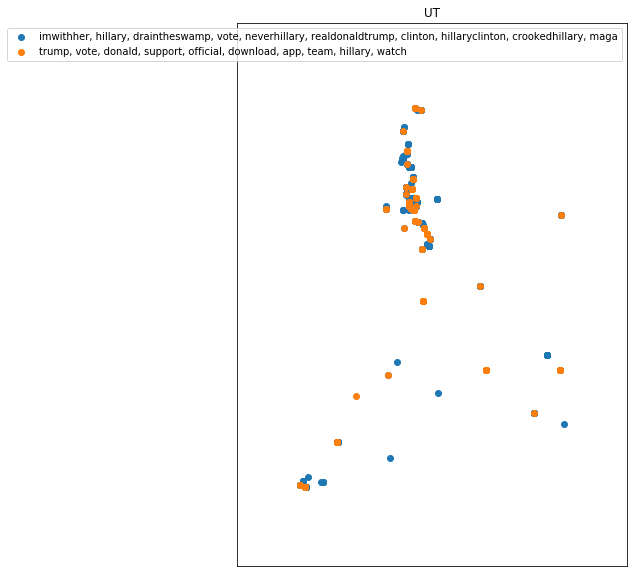

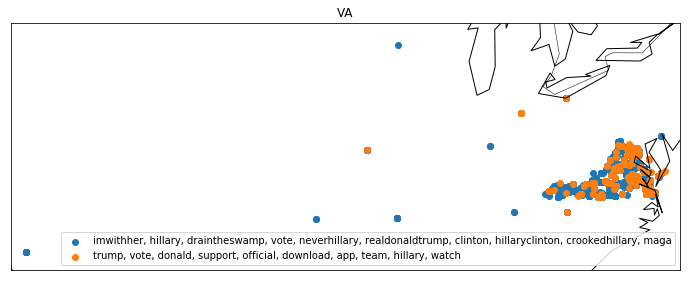

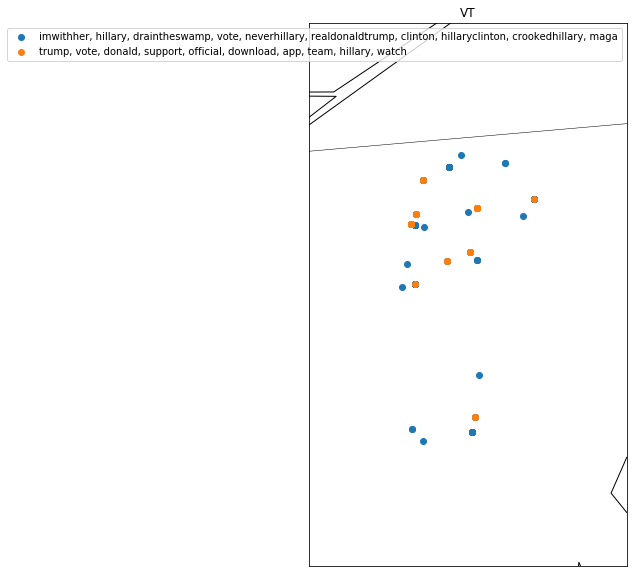

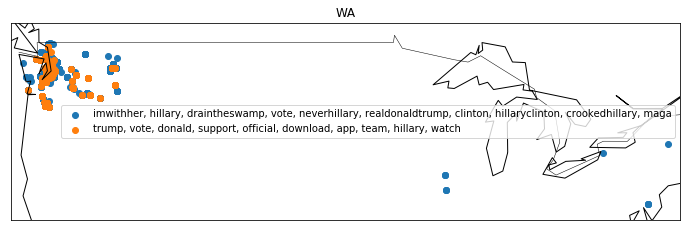

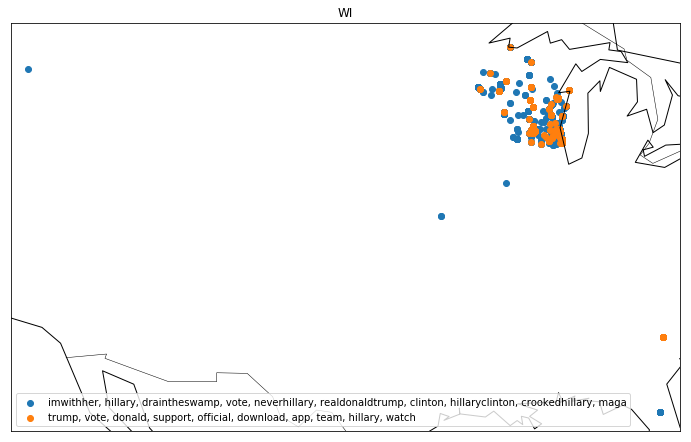

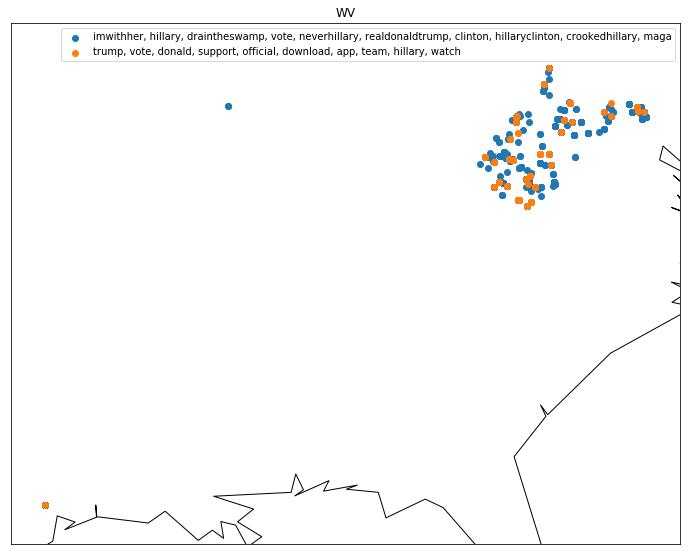

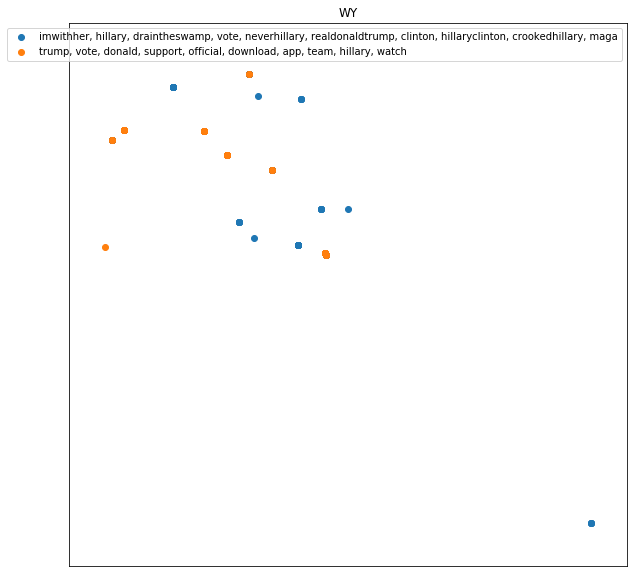

In [74]:
for state, dataframe in all_df.groupby('state'):
    if len(state) == 2:
        plot_map_kmeans_labels(dataframe, clusters2_dict, '2clusters', state)